# Demographics and Distributions

In [1]:
import pandas as pd
import numpy as np
from importlib import reload
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pingouin as pg
import matplotlib.gridspec as gridspec

/Users/dadler/miniforge3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
sys.path.insert(0, '../code/')

In [3]:
import util

In [4]:
palette = sns.color_palette('tab10')[0:2]

### Open Data

In [5]:
crosscheck = pd.read_csv('../data/crosscheck_daily_data_cleaned_w_sameday.csv', index_col=0)

In [6]:
studentlife = pd.read_csv('../data/studentlife_daily_data_cleaned_w_sameday_08282021.csv')

## Prep for models

### Get features

In [7]:
# EMA cols
ema_cols_crosscheck = [i for i in crosscheck.columns if 'ema' in i]
ema_cols_studentlife = [i for i in studentlife.columns if 'ema' in i]

In [8]:
# Behavior cols
behavior_cols_crosscheck = [
    i for i in crosscheck.columns if i not in ['study_id', 'eureka_id', 'date'] + ema_cols_crosscheck
]

behavior_cols_studentlife = [
    i for i in studentlife.columns if i not in ['study_id', 'eureka_id', 'day'] + ema_cols_studentlife
]

behavior_cols = list(set(behavior_cols_crosscheck) & set(behavior_cols_studentlife))
behavior_cols.sort()

In [9]:
features = behavior_cols[:]

### Clean for model training

In [10]:
crosscheck_temp = crosscheck.copy()
crosscheck_temp[behavior_cols] = crosscheck_temp[behavior_cols].fillna(0)

features = [f for f in features if len(crosscheck_temp[f].unique()) > 1]

#### Transform StudentLife EMA to look like CrossCheck

In [11]:
studentlife_temp = studentlife[['study_id', 'day'] + 
    behavior_cols + ['ema_Stress_level', 'ema_Sleep_rate', 'ema_Behavior_calm', 'ema_Mood_sad', 'ema_Mood_sadornot']
].reset_index(drop=True).copy() # TEMP FILL

# Fill NA
non_sleep_loc_cols = [i for i in behavior_cols if ('loc' not in i) and ('sleep' not in i)]
studentlife_temp[non_sleep_loc_cols] = studentlife_temp[non_sleep_loc_cols].fillna(0)

# Fill sleep with average value for that individual
for s in studentlife_temp.study_id.unique():
    temp = studentlife_temp.loc[studentlife_temp.study_id == s, :]
    duration_mean = temp['sleep_duration'].mean()
    start_mean = temp['sleep_start'].mean()
    end_mean = temp['sleep_end'].mean()
    ind = (studentlife_temp.study_id == s) & pd.isnull(studentlife_temp['sleep_duration'])
    studentlife_temp.loc[ind, 'sleep_duration'] = duration_mean
    studentlife_temp.loc[ind, 'sleep_start'] = start_mean
    studentlife_temp.loc[ind, 'sleep_end'] = end_mean

# Drop days without location (14 total) and days still w/o sleep (all IDs with no sleep info)
studentlife_temp = studentlife_temp.dropna(subset=behavior_cols).reset_index()

In [12]:
# Need to map all of them from 0-3

# Stress [1]A little stressed, [2]Definitely stressed, [3]Stressed out, [4]Feeling good, [5]Feeling great, 
studentlife_temp['ema_STRESSED'] = studentlife_temp['ema_Stress_level'].map({
    5:0, 4:0, 1:1, 2:2, 3:3
})
# Map from 0 - 3
minimum = studentlife_temp['ema_STRESSED'].min()
maximum = studentlife_temp['ema_STRESSED'].max()
studentlife_temp['ema_STRESSED'] =  3 * (studentlife_temp['ema_STRESSED'] - minimum) / (maximum - minimum)


# Sleeping [1]Very good, [2]Fairly good, [3]Fairly bad, [4]Very bad, 
# Map from 0 - 3
studentlife_temp['ema_SLEEPING'] = 4 - studentlife_temp['ema_Sleep_rate'].round().copy()

In [13]:
targets = ['ema_SLEEPING', 'ema_STRESSED']
studentlife_temp['data'] = 'sl'
crosscheck_temp['data']= 'cc'

### Base models CV

In [17]:
sleep_study_ids = studentlife_temp[[targets[0], 'study_id']].dropna().study_id.value_counts()
sleep_study_ids = sleep_study_ids[sleep_study_ids >= 30]
print(len(studentlife_temp[targets[0]].dropna()), sleep_study_ids.sum(), len(sleep_study_ids))
print(sleep_study_ids.agg(['median', util.percentile(25), util.percentile(75)]))

1079 597 15
median           38.0
percentile_25    33.0
percentile_75    48.0
Name: study_id, dtype: float64


In [18]:
stress_study_ids = studentlife_temp[[targets[1], 'study_id']].dropna().study_id.value_counts()
stress_study_ids = stress_study_ids[stress_study_ids >= 30]
print(len(studentlife_temp[targets[1]].dropna()), stress_study_ids.sum(), 
      len(stress_study_ids)) 
print(stress_study_ids.agg(['median', util.percentile(25), util.percentile(75)]))

902 307 9
median           33.0
percentile_25    32.0
percentile_75    36.0
Name: study_id, dtype: float64


In [20]:
crosscheck_study_ids = crosscheck_temp.study_id.value_counts()
crosscheck_study_ids = crosscheck_study_ids[crosscheck_study_ids >= 30]
print(crosscheck_temp.shape[0], crosscheck_study_ids.sum(), len(crosscheck_study_ids))
print(crosscheck_study_ids.agg(['median', util.percentile(25), util.percentile(75)]))

5853 5665 51
median           124.0
percentile_25     80.0
percentile_75    141.0
Name: study_id, dtype: float64


### Demographic Distributions

In [21]:
# Get features
features = [f for f in features if ('0' in f)]
features = [
    f for f in features if (f != 'act_running_ep_0') and 
    (f != 'act_walking_ep_0') and (f != 'missing_days')
]
features += ['sleep_start', 'sleep_end', 'missing_days']


cc = crosscheck_temp.loc[crosscheck_temp.study_id.isin(crosscheck_study_ids.index), :]
sl_sleep = studentlife_temp.loc[
    studentlife_temp.study_id.isin(sleep_study_ids.index), 
    features + ['study_id', 'ema_SLEEPING']].dropna()
sl_stress = studentlife_temp.loc[
    studentlife_temp.study_id.isin(sleep_study_ids.index),
    features + ['study_id', 'ema_STRESSED']].dropna()

cc['Dataset'] = 'CC'
sl_sleep['Dataset'] = 'SL: Sleep'
sl_stress['Dataset'] = 'SL: Stress'
cols = features + ['Dataset', 'study_id']
data = pd.concat([cc[cols], sl_sleep[cols], sl_stress[cols]])

/var/folders/jz/qkzf_x696_sc2q1zjc3j7kh80000gp/T/ipykernel_74746/3419920286.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc['Dataset'] = 'CC'


In [22]:
features_dict = dict(
    zip(features, 
    ['Activity: On Foot', 'Activity: Still', 'Activity: Unknown', 'Conversatons: Duration', 
     'Conversations: Number', 'Location: Distance', 
     'Location: Number Visited', 'Unlock: Duration',
     'Sleep: Start', 'Sleep: End', 
     'Missing Days']
))

y_labels_dict = dict(
    zip(features, 
    ['Hours', 'Hours', 'Hours', 'Hours', 
     'Number', 'Kilometers', 'Numbers', 'Hours',
     '7.5 Minute Epochs\nfrom 8PM', '7.5 Minute Epochs\nfrom 8PM', 
     'Count']
))

In [23]:
data[
    ['act_on foot_ep_0', 'act_still_ep_0', 'act_unknown_ep_0',
     'audio_convo_duration_ep_0', 'unlock_duration_ep_0']
] /= 3600
data[['loc_dist_ep_0']] /= 1000
data_melt = pd.melt(data, id_vars='Dataset', value_vars=features)

In [24]:
temp = data_melt.loc[data_melt.variable == 'missing_days', :]

act_on foot_ep_0 SL: Sleep Normality 0.0 Test stat: 0.0 0.71
act_on foot_ep_0 SL: Stress Normality 0.0 Test stat: 0.0 0.7
act_still_ep_0 SL: Sleep Normality 0.0 Test stat: 0.0 -0.1
act_still_ep_0 SL: Stress Normality 0.0 Test stat: 0.01 -0.07
act_unknown_ep_0 SL: Sleep Normality 0.0 Test stat: 0.0 0.2
act_unknown_ep_0 SL: Stress Normality 0.0 Test stat: 0.0 0.18
audio_convo_duration_ep_0 SL: Sleep Normality 0.0 Test stat: 0.0 0.43
audio_convo_duration_ep_0 SL: Stress Normality 0.0 Test stat: 0.0 0.39
audio_convo_num_ep_0 SL: Sleep Normality 0.0 Test stat: 0.0 0.51
audio_convo_num_ep_0 SL: Stress Normality 0.0 Test stat: 0.0 0.5
loc_dist_ep_0 SL: Sleep Normality 0.0 Test stat: 0.82 -0.01
loc_dist_ep_0 SL: Stress Normality 0.0 Test stat: 0.18 -0.04
loc_visit_num_ep_0 SL: Sleep Normality 0.0 Test stat: 0.0 0.92
loc_visit_num_ep_0 SL: Stress Normality 0.0 Test stat: 0.0 0.9
unlock_duration_ep_0 SL: Sleep Normality 0.0 Test stat: 0.0 0.89
unlock_duration_ep_0 SL: Stress Normality 0.0 Test s

/Users/dadler/miniforge3/lib/python3.9/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))


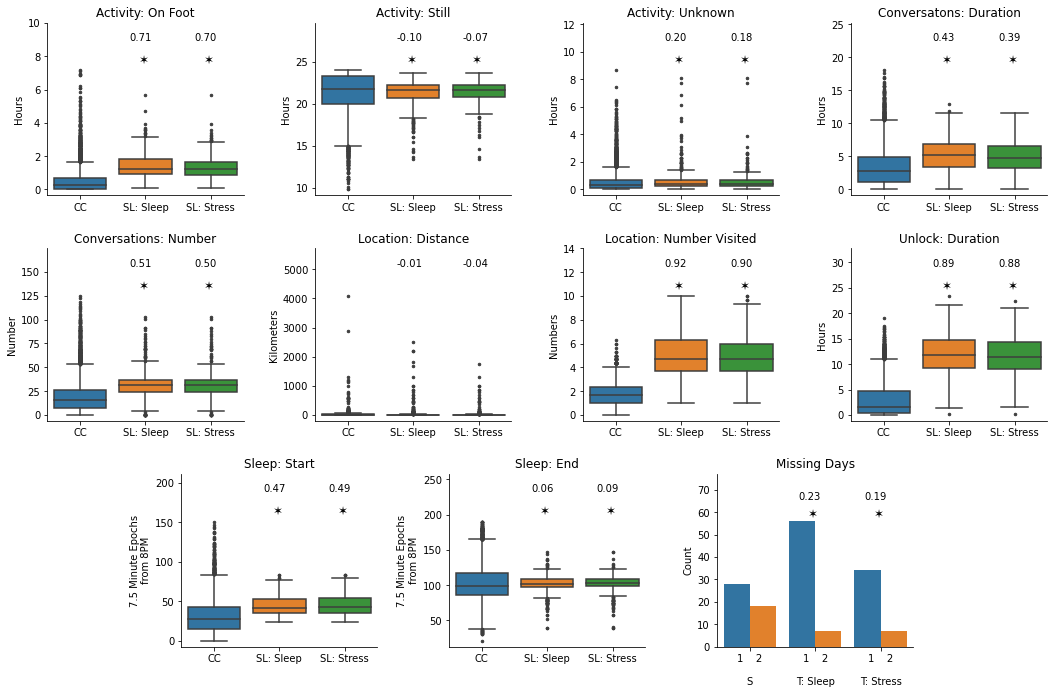

In [31]:
fig = plt.figure(figsize=(15, 10))
curr = 1

gs = gridspec.GridSpec(ncols=8, nrows=3, figure=fig)

curr_row = 0
curr_col_start = 0
curr_col_end = 2

for f in features:
    ax = fig.add_subplot(gs[curr_row, curr_col_start:curr_col_end])
    
    if f != 'missing_days':
        temp = data_melt.loc[data_melt.variable == f, :]
        ax = sns.boxplot(data=temp, x='Dataset', y='value', flierprops={'marker': '.'})
        plt.xlabel('')
        # Run paired test
        x_tick = 1
        max_val = temp['value'].max()
        min_val = temp['value'].min()
        inc = (max_val - min_val) / 20
        plt.ylim(ymax=max_val + inc * 8)
        for y in ['SL: Sleep', 'SL: Stress']:
            test_res = util.non_paired_test(
                x=list(temp.loc[temp.Dataset == 'CC', 'value']), 
                y=list(temp.loc[temp.Dataset == y, 'value'])
            )
            print(f, y, 'Normality', np.round(test_res[1][1], 2), 'Test stat:', 
                  np.round(test_res[0].loc['MWU', 'p-val'], 2), 
                  np.round(test_res[0].loc['MWU', 'RBC'], 2))
            p_val = test_res[0].iloc[0, :]['p-val']
            rbc = test_res[0].iloc[0, :]['RBC']
            text = str(np.round(rbc, 2))
            text += '0' * (2 - len(text.split('.')[1]))
            plt.text(x=x_tick - 0.25, y=max_val + inc * 5, s=text)
            if p_val < .05:
                plt.text(x=x_tick - 0.105, y=max_val + inc, s='✶', size=12)
            x_tick += 1
            
    else:
        temp = data.groupby(['Dataset', 'missing_days'], as_index=False)['study_id'].count()
        temp_nonzero = temp.loc[temp.missing_days > 0, :]
        ax = sns.barplot(data=temp_nonzero, x='Dataset', y='study_id', hue='missing_days')
        # Tests
        temp_test = data_melt.loc[(data_melt.variable == f), :]
        crosstab = pd.crosstab(temp_test['Dataset'], temp_test['value'])
        max_val = crosstab[[1, 2]].max().max()
        min_val = crosstab[[1, 2]].min().max()
        inc = (max_val - min_val) / 20
        plt.ylim(ymax=max_val + inc * 15)
        x_tick = 1
        for y in ['SL: Sleep', 'SL: Stress']:
            stats = pg.chi2_independence(
                temp_test.loc[temp_test.Dataset.isin(['CC', y]), :], 
                x='Dataset', y='value')[2].loc[0]
            p_val = stats.loc['pval']
            cramer = stats.loc['cramer']
            text = str(np.round(cramer, 2))
            text += '0' * (2 - len(text.split('.')[1]))
            plt.text(x=x_tick - 0.25, y=max_val + inc * 7, s=text)
            if p_val < .05:
                plt.text(x=x_tick - 0.105, y=max_val + inc, s='✶', size=12)
            x_tick += 1
        plt.xlabel('')
        ax.get_legend().remove()
        plt.xticks(ticks=[0, 1, 2], labels=['1    2\n\nS', '1    2\n\nT: Sleep', 
                                            '1    2\n\nT: Stress'])
        
    plt.ylabel(y_labels_dict[f])
    plt.title(features_dict[f])
    
    curr_col_start += 2
    curr_col_end += 2
    
    if curr_col_start >= 8:
        if curr_row == 0:
            curr_col_start = 0
            curr_col_end = 2
        else:
            curr_col_start = 1
            curr_col_end = 3
    
        curr_row += 1
    
sns.despine()
plt.tight_layout(pad=2)

In [32]:
sleep_test = util.non_paired_test(
        x=list(cc['ema_SLEEPING']), 
        y=list(sl_sleep['ema_SLEEPING']), 
)
sleep_p_val = sleep_test[0].iloc[0, :]['p-val']
sleep_rbc = sleep_test[0].iloc[0, :]['RBC']
sleep_text = '$RBC=' + str(np.round(sleep_rbc, 2)) + '$'
sleep_text += '0' * (2 - len(sleep_text.split('.')[1]))
if sleep_p_val < .05:
    sleep_text += '\n✶'


stress_test = util.non_paired_test(
        x=list(cc['ema_STRESSED']), 
        y=list(sl_stress['ema_STRESSED']), 
)
stress_p_val = stress_test[0].iloc[0, :]['p-val']
stress_rbc = stress_test[0].iloc[0, :]['RBC']
stress_text = '$RBC=' + str(np.round(stress_rbc, 2)) + '$'
stress_text += '0' * (2 - len(stress_text.split('.')[1]))
if stress_p_val < .05:
    stress_text += '\n✶'

In [44]:
'Sleep', 'P-val', sleep_test[0].loc['MWU', 'p-val'].round(3), \
    'RBC', sleep_test[0].loc['MWU', 'RBC'].round(2)

('Sleep', 'P-val', 0.003, 'RBC', -0.07)

In [43]:
'Stress', 'P-val', stress_test[0].loc['MWU', 'p-val'].round(3), \
    'RBC', stress_test[0].loc['MWU', 'RBC'].round(2)

('Stress', 'P-val', 0.0, 'RBC', 0.37)

/Users/dadler/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


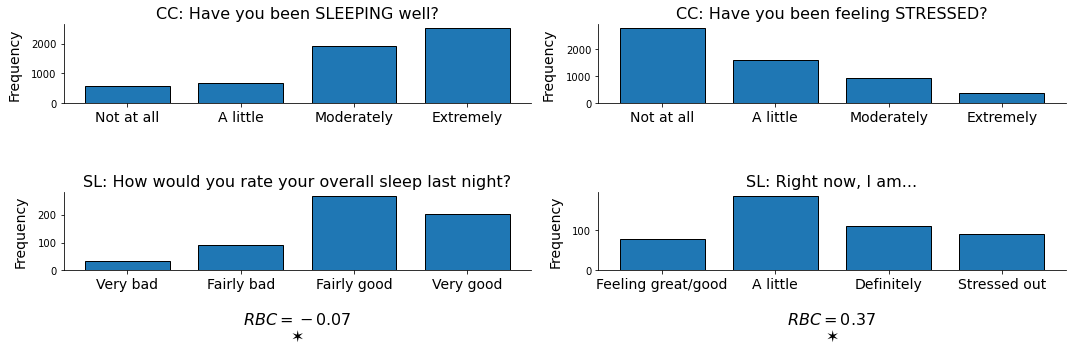

In [45]:
# Plot loss
plt.figure(figsize=(15, 5))

plt.subplot(2, 2, 1)
ax = sns.distplot(cc['ema_SLEEPING'] + 1, kde=False, bins=4,
                 hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0})
sns.despine()
plt.title('CC: Have you been SLEEPING well?', size=16)
mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
plt.xticks(mids, labels=['Not at all', 'A little', 'Moderately', 'Extremely'], size=14)
plt.xlabel('')
plt.ylabel('Frequency', size=14, labelpad=10)

plt.subplot(2, 2, 2)
ax = sns.distplot(cc['ema_STRESSED'], kde=False, bins=4,
            hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0})
sns.despine()
plt.title('CC: Have you been feeling STRESSED?', size=16)
mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
plt.xticks(mids, labels=['Not at all', 'A little', 'Moderately', 'Extremely'], size=14)
plt.xlabel('')
plt.ylabel('Frequency', size=14, labelpad=10)

plt.subplot(2, 2, 3)
ax = sns.distplot(sl_sleep['ema_SLEEPING'], kde=False, bins=4,
            hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0})
sns.despine()
plt.title('SL: How would you rate your overall sleep last night?', size=16)
mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
plt.xticks(mids, labels=['Very bad', 'Fairly bad', 'Fairly good', 'Very good'], size=14)
plt.xlabel(sleep_text, size=16, labelpad=20)
plt.ylabel('Frequency', size=14, labelpad=10)

plt.subplot(2, 2, 4)
ax = sns.distplot(sl_stress['ema_STRESSED'], kde=False, bins=4,
            hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0})
sns.despine()
plt.title('SL: Right now, I am...', size=16)
mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
plt.xticks(mids, size=14,
           labels=['Feeling great/good', 'A little', 'Definitely', 'Stressed out']
          )
plt.xlabel(stress_text, size=16, labelpad=20)
plt.ylabel('Frequency', size=14, labelpad=10)

plt.tight_layout(h_pad=5)
# plt.savefig('../figs/loso_ema_hist_01182020.png', dpi=300)

In [60]:
print('CrossCheck EMA stats')
print(
    cc[['ema_SLEEPING', 'ema_STRESSED']].agg(['median', util.percentile(25), 
                                              util.percentile(75)]))

print()
print('CrossCheck binary sleep counts')
print(cc['ema_SLEEPING'].map({3:0, 2:0, 1:1, 0:1}).value_counts())

print()
print('CrossCheck binary sleep normalized')
print(cc['ema_SLEEPING'].map({3:0, 2:0, 1:1, 0:1}).value_counts(normalize=True))

print()
print('CrossCheck binary stress counts')
print(cc['ema_STRESSED'].map({3:0, 2:0, 1:1, 0:1}).value_counts())

print()
print('CrossCheck binary stress normalized')
print(cc['ema_STRESSED'].map({3:0, 2:0, 1:1, 0:1}).value_counts(normalize=True))

CrossCheck EMA stats
               ema_SLEEPING  ema_STRESSED
median                  2.0           1.0
percentile_25           2.0           0.0
percentile_75           3.0           1.0

CrossCheck binary sleep counts
0    4425
1    1240
Name: ema_SLEEPING, dtype: int64

CrossCheck binary sleep normalized
0    0.781112
1    0.218888
Name: ema_SLEEPING, dtype: float64

CrossCheck binary stress counts
1    4373
0    1292
Name: ema_STRESSED, dtype: int64

CrossCheck binary stress normalized
1    0.771933
0    0.228067
Name: ema_STRESSED, dtype: float64


In [61]:
print('StudentLife Sleep EMA stats')
print(
    sl_sleep[['ema_SLEEPING']].agg(['median', util.percentile(25), 
                                              util.percentile(75)]))
print()
print('StudentLife binary sleep counts')
print(sl_sleep['ema_SLEEPING'].map({3:0, 2:0, 1:1, 0:1}).value_counts())

print()
print('StudentLife binary sleep normalized')
print(sl_sleep['ema_SLEEPING'].map({3:0, 2:0, 1:1, 0:1}).value_counts(normalize=True))

print()
print('StudentLife Stress EMA stats')
print(
    sl_stress[['ema_STRESSED']].agg(['median', util.percentile(25), 
                                              util.percentile(75)]))

print()
print('StudentLife binary stress counts')
print(sl_stress['ema_STRESSED'].map({3:0, 2:0, 1:1, 0:1}).value_counts())

print()
print('StudentLife binary stress normalized')
print(sl_stress['ema_STRESSED'].map({3:0, 2:0, 1:1, 0:1}).value_counts(normalize=True))

StudentLife Sleep EMA stats
               ema_SLEEPING
median                  2.0
percentile_25           2.0
percentile_75           3.0

StudentLife binary sleep counts
0    471
1    126
Name: ema_SLEEPING, dtype: int64

StudentLife binary sleep normalized
0    0.788945
1    0.211055
Name: ema_SLEEPING, dtype: float64

StudentLife Stress EMA stats
               ema_STRESSED
median                  1.0
percentile_25           1.0
percentile_75           2.0

StudentLife binary stress counts
1    263
0    200
Name: ema_STRESSED, dtype: int64

StudentLife binary stress normalized
1    0.568035
0    0.431965
Name: ema_STRESSED, dtype: float64
